<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Compare-against-PRECISE" data-toc-modified-id="Compare-against-PRECISE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare against PRECISE</a></span><ul class="toc-item"><li><span><a href="#Identify-new-components" data-toc-modified-id="Identify-new-components-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify new components</a></span><ul class="toc-item"><li><span><a href="#Component-11" data-toc-modified-id="Component-11-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Component 11</a></span></li></ul></li><li><span><a href="#Investigate-component-weightings" data-toc-modified-id="Investigate-component-weightings-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Investigate component weightings</a></span></li></ul></li></ul></div>

**This notebook is only relevant if you are appending E. coli data to PRECISE**

# Setup

In [13]:
import sys
sys.path.append('../..')

from matplotlib_venn import venn2
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from icaviz.plotting import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
DATA_DIR = '../../data/precise2_data/'
PRECISE_DIR = '../../data/precise_data/'
GENE_DIR = '../../data/annotation/'

In [3]:
precise2 = load_data(X=DATA_DIR+'log_tpm_qc.csv',
                     S=DATA_DIR+'S_95.csv',
                     A=DATA_DIR+'A_95.csv',
                     metadata=DATA_DIR+'metadata_qc.csv',
                     annotation=GENE_DIR+'gene_info.csv',
                     trn=GENE_DIR+'TRN.csv',
                     cutoff = 525) # Get correct cut-off score from 3_estimate_thresholds

../../icaviz/load.py:350: UserWarning: Genes missing annotations: b0012, b0056, b0057, b4726, b4727, b4728, b4710, b4709, b4729, b0282, b4730, b0322, b4731, b4732, b0470_1, b0470_2, b0470_3, b0484_1, b0484_2, b0484_3, b0502, b4733, b0562, b4734, b4581, b4735, b4736, b4723, b4737, b4490, b1142, b1149, b4738, b4739, b4491, b4521, b4740, b1228, b4573, b4711, b4741, b4742, b1318, b4524, b4743, b4744, b4493, b4745, b1459, b1470, b1471, b4746, b4747, b1506, b4696, b1543, b4748, b4749, b4724, b4750, b4534, b4494, b4751, b4752, b4495, b4496, b2092, b2115, b2139, b4604, b4605, b4725, b2641, b4644, b2649, b2681, b4610, b2850, b2854, b2855, b2858, b2862, b4753, b4754, b2941, b4658, b4755, b3036, b4756, b3268, b3423, b4612, b4660, b4615, b3643, b3681, b3682, b4757, b4488, b3777, b3782, b3808, b4038, b4583, b4223, b4575, b4308, b4720, b4721, b4722, b4715, b4584
  warnings.warn('Genes missing annotations: {}'.format(missing_genes))


In [4]:
enrich = pd.read_csv(PRECISE_DIR+'curated_enrichments.csv')
names = enrich['name'].tolist()
precise = load_data(X=PRECISE_DIR+'log_tpm.csv',
                     S=PRECISE_DIR+'S.csv',
                     A=PRECISE_DIR+'A.csv',
                     metadata=PRECISE_DIR+'metadata.csv',
                     annotation=GENE_DIR+'gene_info.csv',
                     trn=GENE_DIR+'TRN.csv',
                     cutoff = 550,names=names)

# Compare against PRECISE

In [8]:
dot,links = compare_ica(precise.S,precise2.S,cutoff=0.3)

You may either view the comparison in the Jupyter notebook, or save it to a png

In [9]:
dot.save('comparison.png')

'comparison.png'

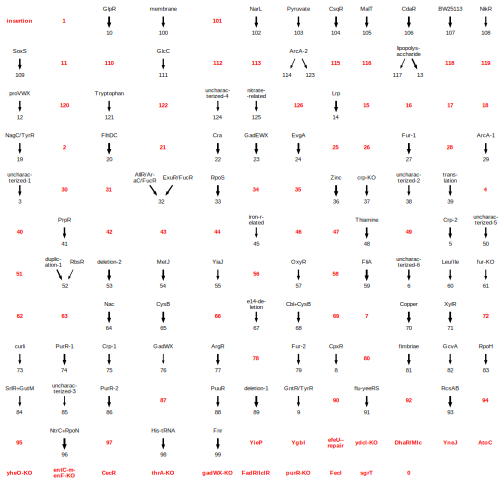

In [10]:
dot

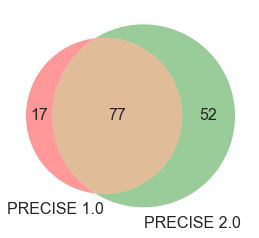

In [13]:
precise_names = precise.names
hmp_names = precise2.names
precise_both, hmp_both = zip(*links)
hmp_both = [int(hmp_name) for hmp_name in hmp_both]
precise_unique = list(set(precise_names).difference(set(precise_both)))
hmp_unique = list(set(hmp_names).difference(set(hmp_both)))

_, ax = plt.subplots()
venn = venn2(subsets=(len(precise_unique), len(hmp_unique), len(precise_both)), set_labels=['PRECISE 1.0', 'PRECISE 2.0'])
for text in venn.subset_labels:
    text.set_fontsize(16)
for text in venn.set_labels:
    text.set_fontsize(16)

## Automatically Create Raw Enrichments

This section only needs to be run once; if component_info.csv exists already in the data directory, then this automated initial step has been taken, and that file should be consulted for further manual annotation

In [14]:
component_info_df = pd.DataFrame(columns=[
    'component', 'name', 'TF', 'log_odds', 'f1score', 'pvalue',
    'precision', 'recall', 'TP', 'n_genes', 'n_tf', 'Regulator',
    'Function', 'Category', 'threshold', 'PRECISE_name'
])

for component_idx in tqdm(range(precise2.S.shape[1])):
    component_info_df.loc[component_idx, 'component'] = component_idx
    
    precise_idx_tup_listed = [tup for tup in links if int(tup[1]) == component_idx]
    if len(precise_idx_tup_listed) == 1:
        precise_name = precise_idx_tup_listed[0][0]
        component_info_df.loc[component_idx, 'PRECISE_name'] = precise_name
        precise_enrich_row = enrich[enrich['name'] == precise_name]
        component_info_df.loc[component_idx, 'Function'] = precise_enrich_row['Function'].values[0]
        component_info_df.loc[component_idx, 'Category'] = precise_enrich_row['Category'].values[0]
    
    component_info_df.loc[component_idx, 'threshold'] = precise2.thresholds[component_idx]
    
    genes = precise2.show_enriched(component_idx).index
    component_info_df.loc[component_idx, 'n_genes'] = len(genes)
    
    all_genes = precise2.X.index
    enrichment_df = compute_enrichments(genes, all_genes, precise2.trn, max_tfs = 1, fdr_rate=1e-5)
    if enrichment_df.shape[0] > 0:
        tf_name = enrichment_df.index[0]
        component_info_df.loc[component_idx, 'Regulator'] = tf_name
        component_info_df.loc[component_idx, 'log_odds'] = enrichment_df.loc[tf_name, 'log_odds']
        component_info_df.loc[component_idx, 'pvalue'] = enrichment_df.loc[tf_name, 'pvalue']
        component_info_df.loc[component_idx, 'recall'] = enrichment_df.loc[tf_name, 'recall']
        component_info_df.loc[component_idx, 'precision'] = enrichment_df.loc[tf_name, 'precision']
        component_info_df.loc[component_idx, 'TP'] = enrichment_df.loc[tf_name, 'TP']
        component_info_df.loc[component_idx, 'f1score'] = enrichment_df.loc[tf_name, 'f1score']
        component_info_df.loc[component_idx, 'n_tf'] = enrichment_df.loc[tf_name, 'n_tf']

/Users/cam/.virtualenvs/precise2/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
component_info_df

,component,name,TF,log_odds,f1score,pvalue,precision,recall,TP,n_genes,n_tf,Regulator,Function,Category,threshold,PRECISE_name
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,0.076643,NaN
1,1,NaN,NaN,5.10157,0.212766,4.60645e-09,0.131579,0.555556,5,38,1,dcuR,NaN,NaN,0.0594992,NaN
2,2,NaN,NaN,inf,0.078125,1.61397e-08,1,0.0406504,5,5,1,narL,NaN,NaN,0.132505,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,NaN,NaN,Unknown Function,Uncharacterized,0.0500994,uncharacterized-1
4,4,NaN,NaN,7.28184,0.615385,4.43955e-19,0.666667,0.571429,8,12,1,paaX,NaN,NaN,0.0928828,NaN
5,5,NaN,NaN,inf,0.232558,3.74932e-11,0.131579,1,5,38,1,gatR,Various carbon source catabolism,Carbon Source Utilization,0.0469745,Crp-2
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,NaN,NaN,Unknown Function,Uncharacterized,0.042249,uncharacterized-6
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,0.117304,NaN
8,8,NaN,NaN,3.94096,0.285714,2.04201e-18,0.375,0.230769,15,40,1,cpxR,Various stress responses,Stress Response,0.0545015,CpxR
9,9,NaN,NaN,7.97568,0.695652,2.44528e-20,0.727273,0.666667,8,11,1,gntR,Gluconate catabolism and tyrosine biosynthesis,Carbon Source Utilization,0.084385,GntR/TyrR


In [18]:
component_info_df.to_csv('../../data/precise2_data/component_info.csv')

## Identify new components

In [449]:
COMPONENT_NAME = 126

In [450]:
precise2.show_enriched(COMPONENT_NAME)

,comp,product,gene_name,operon,length,TF
Synonym,,,,,,
b3454,-0.105925,branched chain amino acid / phenylalanine ABC ...,livF,"livK,livH,livM,livG,livF",714.0,"Sigma70,lrp"
b4183,0.122507,conserved protein,yjfK,"yjfK,yjfL,yjfM,yjfC",660.0,
b4182,0.165548,predicted transcriptional regulator effector p...,yjfJ,"nsrR,rnr,rlmB,yjfI,yjfJ",699.0,
b4181,0.185865,conserved protein,yjfI,"nsrR,rnr,rlmB,yjfI,yjfJ",402.0,


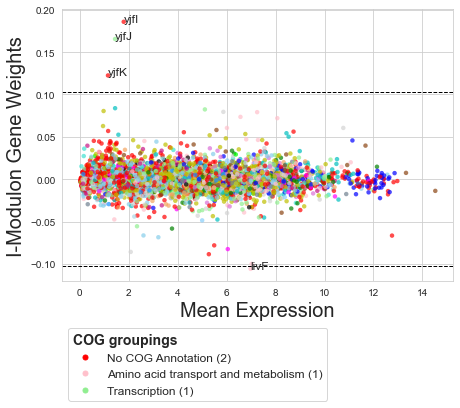

In [451]:
plot_genes(precise2, COMPONENT_NAME, labels=True, adjust=False)

[(<matplotlib.axes._subplots.AxesSubplot at 0x14a0d6dd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x14a1c5310>)]

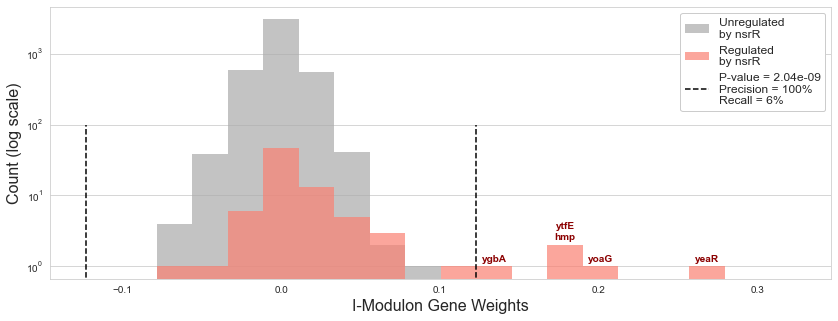

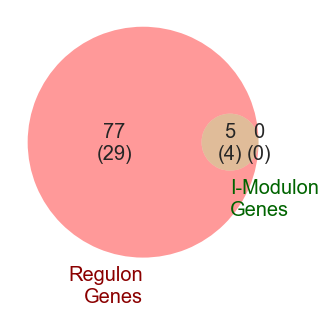

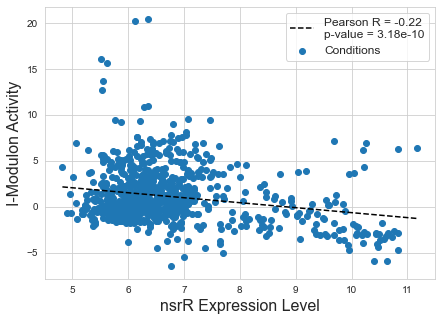

In [448]:
plot_regulon(precise2, COMPONENT_NAME)

In [443]:
genes = precise2.show_enriched(COMPONENT_NAME).index
all_genes = precise2.X.index
compute_enrichments(genes, all_genes, precise2.trn, max_tfs = 2, fdr_rate=1e-5)

,log_odds,pvalue,recall,precision,TP,qvalue,f1score,n_tf
narP+arcA,8.198364,4.038265e-25,0.769231,0.714286,10.0,3.009678e-20,0.740741,2
narP+fis,7.098376,1.297852e-22,0.526316,0.714286,10.0,4.836381e-18,0.606061,2
iscR+arcA,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
ydeO+narL,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
ydeO+fis,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
iscR+appY,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
narP+appY,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
fis+appY,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
narL+appY,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2
iscR+fis,inf,3.076992e-16,1.000000,0.428571,6.0,1.146626e-12,0.600000,2


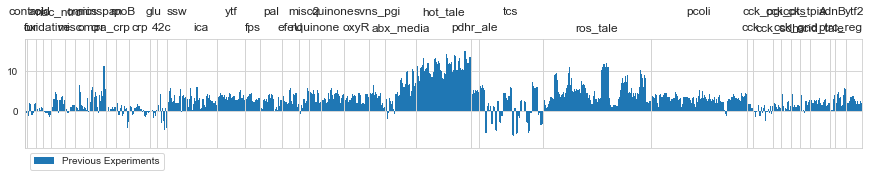

In [452]:
plot_samples_bar(precise2, COMPONENT_NAME)